In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import spikeinterface as si
import matplotlib.pyplot as plt
import os
from matplotlib.backends.backend_pdf import PdfPages

from tqdm import tqdm

In [2]:
import sys
import spikeinterface as si
import matplotlib.pyplot as plt
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import probeinterface

from probeinterface import Probe, ProbeGroup
from probeinterface.plotting import plot_probe, plot_probegroup
from probeinterface import generate_dummy_probe, generate_linear_probe
from probeinterface import write_probeinterface, read_probeinterface
from probeinterface import write_prb, read_prb
from torch.nn.functional import max_pool1d

In [3]:
channel_indices = {
        "1": [1, 3, 5, 7, 9, 11],
        "2": [13, 15, 17, 19, 21, 23],
        "3": [24, 25, 26, 27, 28, 29],
        "4": [12, 14, 16, 18, 20, 22],
        "5": [0, 2, 4, 6, 8, 10]
        }
channel_position = {
    0: [650, 0],
    2: [650, 50],
    4: [650, 100],
    6: [600, 100],
    8: [600, 50],
    10: [600, 0],
    1: [0, 0],
    3: [0, 50],
    5: [0, 100],
    7: [50, 100],
    9: [50, 50],
    11: [50, 0],
    13: [150, 200], 
    15: [150, 250],
    17: [150, 300],
    19: [200, 300],
    21: [200, 250],
    23: [200, 200],
    12: [500, 200],
    14: [500, 250],
    16: [500, 300],
    18: [450, 300],
    20: [450, 250],
    22: [450, 200],
    24: [350, 400],
    26: [350, 450],
    28: [350, 500],
    25: [300, 400],
    27: [300, 450],
    29: [300, 500]}

In [ ]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_021322_natural_image001.ns4')
recording_recorded = recording_raw.remove_channels(["98", '31', '32'])
recording_stimulated = recording_raw.channel_slice(['98'])

recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_f = spre.common_reference(recording_f, reference="global", operator="median")

In [5]:
from scipy.signal import butter, filtfilt
import torch

def get_highpass_filter(fs=10000, cutoff=300, device=torch.device('cuda')):
    """Filter to use for high-pass filtering."""
    NT = 30122
    
    # a butterworth filter is specified in scipy
    b,a = butter(3, cutoff, fs=fs, btype='high')

    # a signal with a single entry is used to compute the impulse response
    x = np.zeros(NT)
    x[NT//2] = 1

    # symmetric filter from scipy
    hp_filter = filtfilt(b, a , x).copy()
    
    hp_filter = torch.from_numpy(hp_filter).to(device).float()
    return hp_filter

In [6]:
from torch.fft import fft, ifft, fftshift

def fft_highpass(hp_filter, NT=30122):
    """Convert filter to fourier domain."""
    device = hp_filter.device
    ft = hp_filter.shape[0]

    # the filter is padded or cropped depending on the size of NT
    if ft < NT:
        pad = (NT - ft) // 2
        fhp = fft(torch.cat((torch.zeros(pad, device=device), 
                             hp_filter,
                             torch.zeros(pad + (NT-pad*2-ft), device=device))))
    elif ft > NT:
        crop = (ft - NT) // 2 
        fhp = fft(hp_filter[crop : crop + NT])
    else:
        fhp = fft(hp_filter)
    return fhp

In [7]:
def get_whitening_matrix(f, nskip=25):
    """Get the whitening matrix, use every nskip batches."""
    n_chan = len(f.chan_map)
    # collect the covariance matrix across channels
    CC = torch.zeros((n_chan, n_chan), device=f.device)
    k = 0
    for j in range(0, f.n_batches-1, nskip):
        # load data with high-pass filtering (see the Binary file class)
        X = f.padded_batch_to_torch(j)        
        
        # remove padding
        X = X[:, f.nt : -f.nt]

        # cumulative covariance matrix
        CC = CC + (X @ X.T)/X.shape[1]
        
        k+=1
        
    CC = CC / k

In [8]:
def whitening_from_covariance(CC):
    """Whitening matrix for a covariance matrix CC.

    This is the so-called ZCA whitening matrix.

    """
    E,D,V =  torch.linalg.svd(CC)
    eps = 1e-6
    Wrot =(E / (D+eps)**.5) @ E.T
    return Wrot

In [9]:
def whitening_local(CC, xc, yc, nrange=32, device=torch.device('cuda')):
    """Compute whitening filter for each channel based on nearest channels."""
    Nchan = CC.shape[0]
    Wrot = torch.zeros((Nchan,Nchan), device = device)

    # for each channel, a local covariance matrix is extracted
    # the whitening matrix is computed for that local neighborhood
    for j in range(CC.shape[0]):
        ds = (xc[j] - xc)**2 + (yc[j] - yc)**2
        isort = np.argsort(ds)
        ix = isort[:nrange]

        wrot = whitening_from_covariance(CC[np.ix_(ix, ix)])

        # the first row of wrot is a whitening vector for the center channel
        Wrot[j, ix] = wrot[0]
    return Wrot

In [10]:
results = {}

In [11]:
results['raw'] = recording_f.get_traces().astype("float32")

In [12]:
import torch
results['raw'] = torch.tensor(results['raw'])
results['raw_2'] = results['raw'] - results['raw'].mean(1).unsqueeze(1)
results['CAR'] = results['raw_2'] - torch.median(results['raw_2'], 0)[0]

In [13]:
hp_filter = get_highpass_filter(fs=10000, cutoff=300, device=torch.device('cpu'))
fwav = fft_highpass(hp_filter, NT=results['CAR'].shape[1])
results['fft'] = torch.real(ifft(fft(results['CAR']) * torch.conj(fwav)))
results['fft'] = fftshift(results['fft'], dim = -1)

In [14]:
xc = np.load("xc.npy")
yc = np.load("yc.npy")

In [15]:
n_chan = results['fft'].size()[1]
CC = torch.zeros((n_chan, n_chan), device='cpu')
X = results['fft'].T[:, 61:-61]
CC = CC + (X @ X.T)/X.shape[1]
Wrot = whitening_local(CC, xc, yc, nrange=32, device='cpu')


In [16]:
results['whitened'] = results['fft'] @ Wrot 

In [17]:
import pickle
with open('neuron_inf.pkl', 'rb') as f:
    neuron_inf = pickle.load(f)

In [18]:
for i in range(len(neuron_inf)):
    temp = neuron_inf['channel_waveform'].values[i]
    
    zero_cols = [j for j in range(temp.shape[1]) if np.sum(temp[:, j]) == 0]
    
    if zero_cols:
        print(f"Detect zero in neuron {neuron_inf['Neuron'].values[i]}, columns: {zero_cols}")
        
        new_waveform = np.delete(temp, zero_cols, axis=1)
        neuron_inf.at[i, 'channel_waveform'] = new_waveform
        
        channel_id_list = neuron_inf['channel_id'].values[i]  
        new_channel_id = [ch for idx, ch in enumerate(channel_id_list) if idx not in zero_cols]
        neuron_inf.at[i, 'channel_id'] = new_channel_id

In [288]:
# for i in range(len(neuron_inf)):
#     channel_id = neuron_inf['channel_id'].values[i]
#     channel_waveform = neuron_inf['channel_waveform'].values[i]
#     del_channel = []

#     waveform_max = channel_waveform.max()
#     for channel in range(channel_waveform.shape[1]):
#         if abs(channel_waveform[:, channel]).max() < waveform_max * 0.4:
#             del_channel.append(channel)
    
#     if del_channel:
#         mask = np.ones(channel_waveform.shape[1], dtype=bool)
#         mask[del_channel] = False
        
#         channel_waveform = channel_waveform[:, mask]
#         channel_id = [channel_id[j] for j in range(len(channel_id)) if j not in del_channel]    
    
#     neuron_inf['channel_id'].values[i] = channel_id
#     neuron_inf['channel_waveform'].values[i] = channel_waveform

In [19]:
spike_inf = pd.read_csv('spike_inf.tsv', sep='\t')

In [20]:
def count_array2_in_range_of_array1(array1, array2, threshold=5):
    sorted_array1 = np.sort(array1)
    
    lefts = array2 - threshold
    rights = array2 + threshold
    
    left_indices = np.searchsorted(sorted_array1, lefts, side='left')
    
    right_indices = np.searchsorted(sorted_array1, rights, side='right')
    
    has_within_range = right_indices > left_indices
    
    count = np.sum(has_within_range)
    
    return count

In [28]:
ratio_in = []
ratio_compare = []
spike_train = {}
for i in range(len(neuron_inf)):
    win_size = 5

    U = neuron_inf['channel_waveform'].values[i].copy().T 
    U = torch.tensor(U)

    X = results['whitened'].T 
    X = X[neuron_inf['channel_id'].values[i], :]

    U_normalize = U/(U**2).sum()**.5

    scores_raw = np.dot(U_normalize, X)
    scores_raw = np.mean(scores_raw, axis = 0)

    scores = np.dot(U_normalize, X) ** 2
    scores = scores.max(axis= 0)

    pad = U.shape[1]
    scores = torch.tensor(scores)

    pooled = max_pool1d(
        scores.unsqueeze(0).unsqueeze(0),
        kernel_size=win_size,
        stride=1,
        padding=win_size//2
    ).squeeze()

    is_peak = (scores == pooled) & (torch.abs(pooled) > pooled.mean() * 5 ) & (scores_raw > 0)
    spike_train[neuron_inf['Neuron'].values[i]] = np.where(is_peak.numpy())[0]

    spike_inf_temp = spike_inf[spike_inf['cluster'] == int(neuron_inf['cluster'].values[i])]
    ratio_in.append(count_array2_in_range_of_array1(spike_train[neuron_inf['Neuron'].values[i]], spike_inf_temp['time'].values, threshold=15) / len(spike_inf_temp['time']))
    ratio_compare.append(len(spike_train[neuron_inf['Neuron'].values[i]]) / len(spike_inf_temp))

<Axes: >

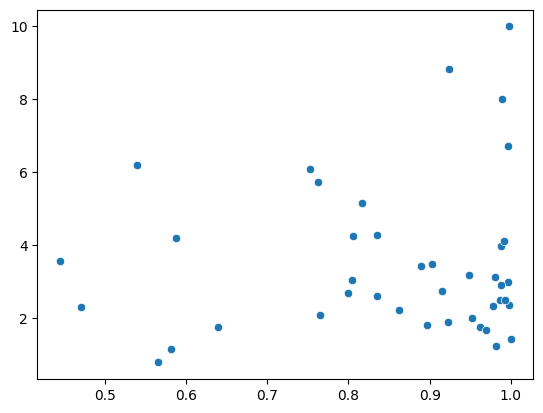

In [29]:
sns.scatterplot(x = ratio_in, y = ratio_compare)

In [ ]:
sns.heatmap

In [444]:
print(ratio_in)
print(ratio_compare)

[0.7446766267930709]
[3.092768154067603]


IndexError: list index out of range

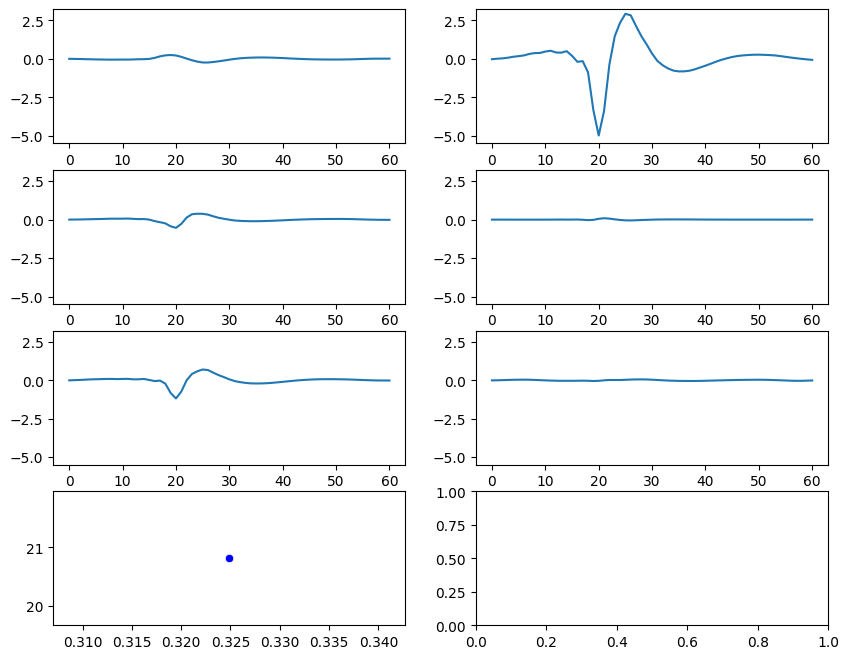

In [369]:
from matplotlib.backends.backend_pdf import PdfPages

with PdfPages("waveform_template.pdf") as pdf:
    for i in [1]:
        neuron = neuron_inf['Neuron'].values[i]
        waveform = neuron_inf[neuron_inf['Neuron'] == neuron]['channel_waveform'].values[0]
        fig, axes = plt.subplots(4, 2, figsize=(10, 8))
        axes = axes.flatten()

        y_min = waveform.min() * 1.1
        y_max = waveform.max() * 1.1
        for j in range(waveform.shape[1]):
            ax = axes[j]
            sns.lineplot(x=range(61), y=waveform[:, j], ax=ax)
            ax.set_ylim(y_min, y_max)

        ax = axes[6]
        sns.scatterplot(x=ratio_in,
                        y=ratio_compare,
                        ax=ax,
                        color='blue') 
        ax.scatter(ratio_in[i], ratio_compare[i], color='red') 
        ax.set_ylim(0, 10)
        ax.set_xlim(0, 1.1)
        
        ax = axes[7]
        spike_inf_temp = spike_inf[spike_inf['cluster'] == int(neuron_inf['cluster'].values[i])]
        ax.text(0.5, 0.8, f'Num of spike train: {len(spike_train[neuron_inf["Neuron"].values[i]])}',
                fontsize=12, ha='center', va='center', transform=ax.transAxes)
        ax.text(0.5, 0.6, f'Num of true spikes: {len(spike_inf_temp["time"])}',
                fontsize=12, ha='center', va='center', transform=ax.transAxes)
        ax.axis('off')

        plt.suptitle(neuron)  
        pdf.savefig(figure=fig)
        plt.close()

<Axes: >

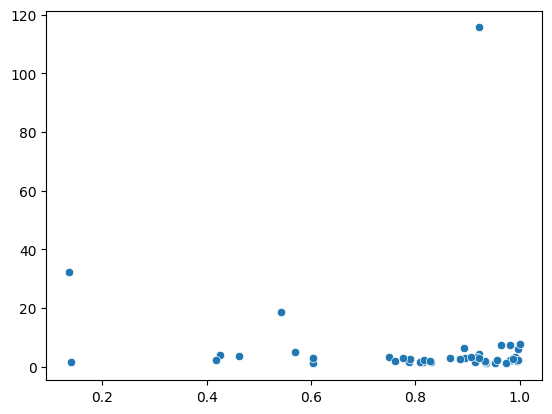

In [23]:
sns.scatterplot(x = ratio_in,
                y = ratio_compare)

In [134]:
with PdfPages("ration.pdf") as pdf:
    for split in [40, 45, 50, 55, 60]:
        ratio_in = []
        ratio_compare = []
        spike_train = {}
        for i in range(len(neuron_inf)):
            win_size = 5

            U = neuron_inf['channel_waveform'].values[i].copy().T 
            U = torch.tensor(U)[:, 10:split]

            X = results['whitened'].T 
            X = X[neuron_inf['channel_id'].values[i], :]

            U_normalize = U/(U**2).sum()**.5
            scores = np.dot(U_normalize.T, X) ** 2
            scores = scores.max(axis= 0)

            pad = U.shape[1]
            scores = torch.tensor(scores)

            pooled = max_pool1d(
                scores.unsqueeze(0).unsqueeze(0),
                kernel_size=win_size,
                stride=1,
                padding=win_size//2
            ).squeeze()

            is_peak = (scores == pooled) & (torch.abs(pooled) >pooled.mean() * 7.5)
            spike_train[neuron_inf['Neuron'].values[i]] = np.where(is_peak.numpy())[0]

            spike_inf_temp = spike_inf[spike_inf['cluster'] == int(neuron_inf['cluster'].values[i])]
            ratio_in.append(count_array2_in_range_of_array1(spike_train[neuron_inf['Neuron'].values[i]], spike_inf_temp['time'].values, threshold=15) / len(spike_inf_temp['time']))
            ratio_compare.append(len(spike_train[neuron_inf['Neuron'].values[i]]) / len(spike_inf_temp))

        plt.figure(figsize=(5,5))
        sns.scatterplot(x = ratio_in,
                        y = ratio_compare)
        plt.title(f'Split: {split}')
        pdf.savefig()
        plt.close()

In [24]:

def find_indices_in_range(array1, array2, threshold=5):
    """
    返回 array1 中满足在 array2 的 ±threshold 范围内的元素的索引。
    
    参数:
    - array1: 主数组，numpy数组
    - array2: 匹配数组，numpy数组
    - threshold: 匹配的阈值范围，默认为5
    
    返回:
    - indices: 满足条件的元素的索引数组
    """
    indices = []
    for i, val in enumerate(array1):
        if np.any(np.abs(array2 - val) <= threshold):
            indices.append(i)
    return np.array(indices)

In [25]:
spike_train_result = {}
for i in range(len(neuron_inf)):
    spike_inf_temp = spike_inf[spike_inf['cluster'] == int(neuron_inf['cluster'].values[i])]
    spike_train_result[neuron_inf['Neuron'].values[i]] = find_indices_in_range(spike_train[neuron_inf['Neuron'].values[i]], spike_inf_temp['time'].values, threshold=15)

In [68]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# 设备配置
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ConvAutoencoder(nn.Module):
    def __init__(self, encoding_dim=2):
        super(ConvAutoencoder, self).__init__()
        
        # 编码器
        self.encoder = nn.Sequential(
            nn.Conv1d(in_channels=6, out_channels=16, kernel_size=3, padding=1),  # (16, 61)
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),  # (16, 30)
            
            nn.Conv1d(16, 32, kernel_size=3, padding=1),  # (32, 30)
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),  # (32, 15)
            
            nn.Conv1d(32, 64, kernel_size=3, padding=1),  # (64, 15)
            nn.ReLU(),
            nn.MaxPool1d(2, stride=2),  # (64, 7)
            
            nn.Flatten(),
            nn.Linear(64*7, encoding_dim)  # 瓶颈层
        )
        
        # 解码器
        self.decoder = nn.Sequential(
            nn.Linear(encoding_dim, 64*7),
            nn.Unflatten(1, (64, 7)),  # (64, 7)
            
            nn.Conv1d(64, 32, kernel_size=3, padding=1),  # (32, 7)
            nn.ReLU(),
            nn.Upsample(scale_factor=2),  # (32, 14)
            
            nn.Conv1d(32, 16, kernel_size=3, padding=1),  # (16, 14)
            nn.ReLU(),
            nn.Upsample(size=30),  # (16, 30)
            
            nn.Conv1d(16, 6, kernel_size=3, padding=1),  # (6, 30)
            nn.ReLU(),
            nn.Upsample(size=61),  # (6, 61)
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded

class ConvAutoencoderReducer:
    def __init__(self, encoding_dim=2, epochs=100, batch_size=128, lr=0.00001):
        self.encoding_dim = encoding_dim
        self.epochs = epochs
        self.batch_size = batch_size
        self.lr = lr
        self.scaler = StandardScaler()
        self.model = None
    
    def fit(self, X):
        # 数据标准化
        original_shape = X.shape
        X_reshaped = X.reshape(-1, original_shape[1] * original_shape[2])
        X_scaled = self.scaler.fit_transform(X_reshaped)
        X_scaled = X_scaled.reshape(original_shape)
        
        # 转换为PyTorch张量
        X_tensor = torch.FloatTensor(X_scaled).to(device)
        dataset = TensorDataset(X_tensor, X_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # 初始化模型
        self.model = ConvAutoencoder(self.encoding_dim).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        
        # 训练循环
        for epoch in range(self.epochs):
            for batch_x, _ in dataloader:
                optimizer.zero_grad()
                reconstructed, _ = self.model(batch_x)
                loss = criterion(reconstructed, batch_x)
                loss.backward()
                optimizer.step()
            
            if (epoch+1) % 10 == 0:
                print(f'Epoch [{epoch+1}/{self.epochs}], Loss: {loss.item():.4f}')
    
    def transform(self, X):
        X_reshaped = X.reshape(-1, X.shape[1] * X.shape[2])
        X_scaled = self.scaler.transform(X_reshaped)
        X_scaled = X_scaled.reshape(X.shape)
        
        with torch.no_grad():
            X_tensor = torch.FloatTensor(X_scaled).to(device)
            _, encoded = self.model(X_tensor)
        
        return encoded.cpu().numpy()
    
    def fit_transform(self, X):
        self.fit(X)
        return self.transform(X)

In [93]:
data_list = []
for i in range(len(spike_train['Neuron_2'])):
    temp = X[:, spike_train['Neuron_2'][i] - 30: spike_train['Neuron_2'][i] + 31].numpy() * 100
    data_list.append(temp)


for i in range(len(spike_train['Neuron_1'])):
    temp = X[:, spike_train['Neuron_1'][i] - 30: spike_train['Neuron_1'][i] + 31].numpy() * 100
    data_list.append(temp)

data = np.array(data_list)


In [109]:
from sklearn.decomposition import PCA
import numpy as np

flattened_data = data.reshape(data.shape[0], -1)

# PCA降维
pca = PCA(n_components=10)
reduced_data = pca.fit_transform(flattened_data)

In [102]:
reducer = ConvAutoencoderReducer(encoding_dim=3, epochs=20)
embeddings = reducer.fit_transform(data)


Epoch [10/20], Loss: 0.9856
Epoch [20/20], Loss: 0.9644


In [96]:
label = np.zeros((len(spike_train['Neuron_2']) + len(spike_train['Neuron_1'])))
label[:len(spike_train['Neuron_2'])] = 1

In [104]:
def visualize_embeddings(embeddings, labels=None, title="ConvAE降维结果"):
    plt.figure(figsize=(8,6))
    if labels is not None:
        plt.scatter(embeddings[:,2], embeddings[:,1], c=labels, cmap='viridis', alpha=0.7)
        plt.colorbar()
    else:
        plt.scatter(embeddings[:,0], embeddings[:,1], alpha=0.7)
    plt.title(title)
    plt.xlabel("编码维度1")
    plt.ylabel("编码维度2")
    plt.grid(True)
    plt.show()

In [121]:
with PdfPages("waveform.pdf") as pdf:
    for i in range(5):
        sns.lineplot(data[i, :, :].T)
        pdf.savefig()
        plt.close()

In [294]:
import cv2

import numpy as np
import cv2

def time_series_template_matching(data, template, method=cv2.TM_CCOEFF_NORMED):
    """
    使用OpenCV对时间序列数据进行模板匹配
    
    参数:
        data (np.ndarray): 数据矩阵，形状为 (n_channels, time)
        template (np.ndarray): 模板矩阵，形状为 (n_channels, t_template)
        method (int): OpenCV模板匹配方法，默认为归一化互相关
    
    返回:
        result (np.ndarray): 匹配结果矩阵，形状为 (data_time - template_time + 1, 1)
        best_match_loc (tuple): 最佳匹配位置 (x, y)
    """
    data = data.astype(np.float32)
    template = template.astype(np.float32)
    
    data_norm = cv2.normalize(data, None, 0, 255, cv2.NORM_MINMAX)
    template_norm = cv2.normalize(template, None, 0, 255, cv2.NORM_MINMAX)
    
    data_T = data_norm.T  
    template_T = template_norm.T  
    
    result = cv2.matchTemplate(data_T, template_T, method)
    
    return result

In [298]:
U = neuron_inf['channel_waveform'].values[i].copy().T 

X = results['whitened'].T 
X = X[neuron_inf['channel_id'].values[i], :].numpy()

In [299]:
result = time_series_template_matching(X, U)

In [309]:
result.shape

torch.Size([40000040, 1])

109002
97704
87067
77032
67986
59638
52064
44998
38635
32736
27500


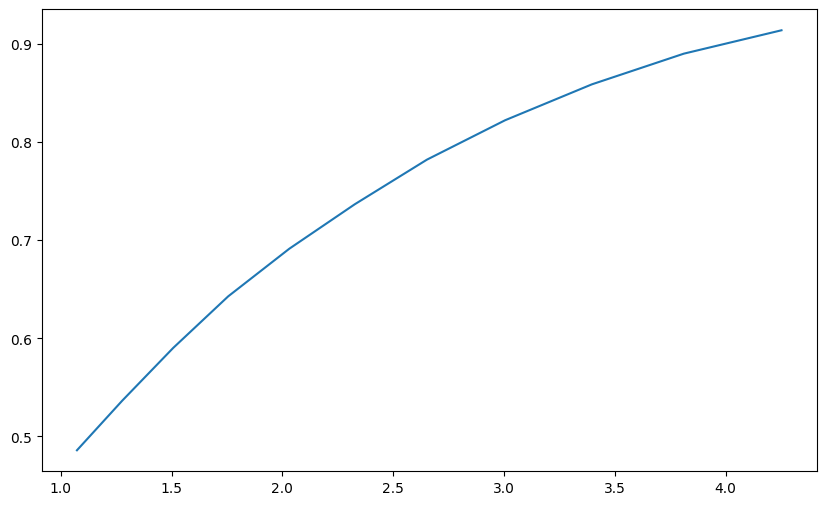

In [359]:
win_size = 21
result = torch.tensor(result)
pooled = max_pool1d(
            result.unsqueeze(0).unsqueeze(0),
            kernel_size=win_size,
            stride=1,
            padding=win_size//2
        ).squeeze()

import numpy as np
import matplotlib.pyplot as plt

thresholds = np.arange(0.3, 0.41, 0.01)  
ratio_in_list = []
ratio_compare_list = []

for threshold in thresholds:
    is_peak = (result == pooled) & (result > threshold)
    spike_train = np.where(is_peak.numpy())[0] + 30  
    print(len(spike_train))
    
    cluster_id = int(neuron_inf['cluster'].values[i]) 
    spike_inf_temp = spike_inf[spike_inf['cluster'] == cluster_id]
    
    ratio_in = count_array2_in_range_of_array1(
        spike_train, 
        spike_inf_temp['time'].values, 
        threshold=15
    ) / len(spike_inf_temp['time'])
    
    ratio_compare = len(spike_train) / len(spike_inf_temp)
    
    # 存储结果
    ratio_in_list.append(ratio_in)
    ratio_compare_list.append(ratio_compare)

plt.figure(figsize=(10, 6))

sns.lineplot(x = ratio_compare_list,
             y = ratio_in_list)
plt.show()

In [ ]:
a, s, V

In [ ]:
    nm = (U**2).sum(-1).sum(-1)
    #mu = nm**.5 
    #U2 = U / mu.unsqueeze(-1).unsqueeze(-1)

    B = conv1d(X.unsqueeze(1), W.unsqueeze(1), padding=nt//2)
    B = torch.einsum('ijk, kjl -> il', U, B)

    trange = torch.arange(-nt, nt+1, device=device) 
    tiwave = torch.arange(-(nt//2), nt//2+1, device=device) 

    st = torch.zeros((100000,2), dtype = torch.int64, device = device)
    amps = torch.zeros((100000,1), dtype = torch.float, device = device)
    k = 0

## 20250522

In [191]:
import pickle
with open('neuron_inf.pkl', 'rb') as f:
    neuron_inf = pickle.load(f)

In [74]:
recording_raw = se.read_blackrock(file_path='/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_021322_natural_image001.ns4')
recording_recorded = recording_raw.remove_channels(["98", '31', '32'])
recording_stimulated = recording_raw.channel_slice(['98'])

recording_f = spre.bandpass_filter(recording_recorded, freq_min=300, freq_max=3000)
recording_f = spre.common_reference(recording_f, reference="global", operator="median")

In [75]:
data = recording_f.get_traces().astype("float32").T

In [148]:
def detect_outliers(data):
    std_dev = np.std(data, keepdims=True, axis=1)

    threshold = 2 * std_dev
    binary_matrix = (data > threshold).astype(int)
    return binary_matrix

In [149]:
threshold_result = detect_outliers(data)

In [192]:
for i in range(len(neuron_inf)):
    U = neuron_inf['channel_waveform'].values[i].copy()
    U_normalize = (U - np.mean(U, keepdims=True)) / \
                    (np.std(U, keepdims=True) + 1e-8)
    neuron_inf['channel_waveform'].values[i] = U_normalize

In [193]:
channel_id = [1, 3, 5, 7, 9, 11]
neuron_temp = neuron_inf[neuron_inf['probe_group'] == "1"]
waveform = np.stack(neuron_temp['channel_waveform'].values)

In [194]:
data_temp = data[channel_id, :]
threshold_result_temp = threshold_result[channel_id, :]
threshold_result_temp = threshold_result_temp.sum(axis=0)
threshold_result_temp = np.where(threshold_result_temp > 0)[0]
threshold_result_temp = threshold_result_temp[threshold_result_temp > 30]
threshold_result_temp = threshold_result_temp[threshold_result_temp < threshold_result_temp.max() - 61]

In [195]:
def compute_max_matching(data, threshold_result_temp, waveform):
    """
    计算每个阈值时间点的最大波形匹配分数。
    
    参数:
    data : numpy.ndarray
        输入数据，形状为 (n_channels, time)
    threshold_result_temp : numpy.ndarray
        包含待检测时间点的数组（整数索引）
    waveform : numpy.ndarray
        波形模板，形状为 (n_template, n_channels, t_template)
        
    返回:
    max_scores : numpy.ndarray
        每个时间点对应的最大匹配分数，形状与 threshold_result_temp 相同
    """
    n_template, n_channels_waveform, t_template = waveform.shape
    n_channels_data, time_length = data.shape
    assert n_channels_data == n_channels_waveform, "通道数不匹配"

    best_template_ids = []
    max_scores = []
    
    half_window = t_template // 2  # 窗口半长（假设 t_template 为奇数）
    max_scores = []
    
    for i in threshold_result_temp:
        start = i - half_window
        end = start + t_template
        
        # 边界处理：跳过越界索引并填充 np.nan
        if start < 0 or end > time_length:
            max_scores.append(np.nan)
            continue
            
        # 截取数据窗口
        window = data[:, start:end]
        window = (window - np.mean(window, keepdims=True)) / \
                            (np.std(window, keepdims=True) + 1e-8)        
        scores = np.einsum('nct,ct->n', waveform, window)
        best_id = np.argmax(scores)  
        best_score = scores[best_id]
        
        best_template_ids.append(best_id)
        max_scores.append(best_score)
    
    return np.array(best_template_ids), np.array(max_scores)

In [196]:
template_ids, max_scores = compute_max_matching(data_temp, threshold_result_temp, waveform)

In [197]:
st = pd.DataFrame((template_ids, max_scores, threshold_result_temp)).T

In [208]:
st.columns = ['template_id', 'max_score', 'time']
st = st[st['max_score'] > 40]

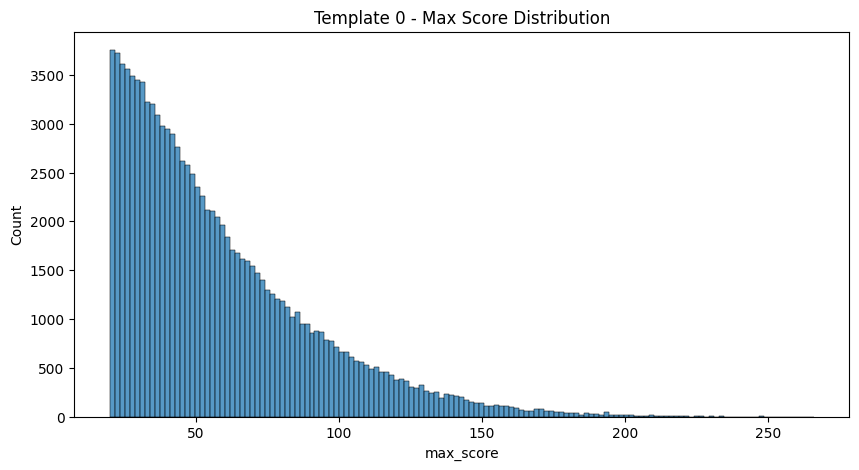

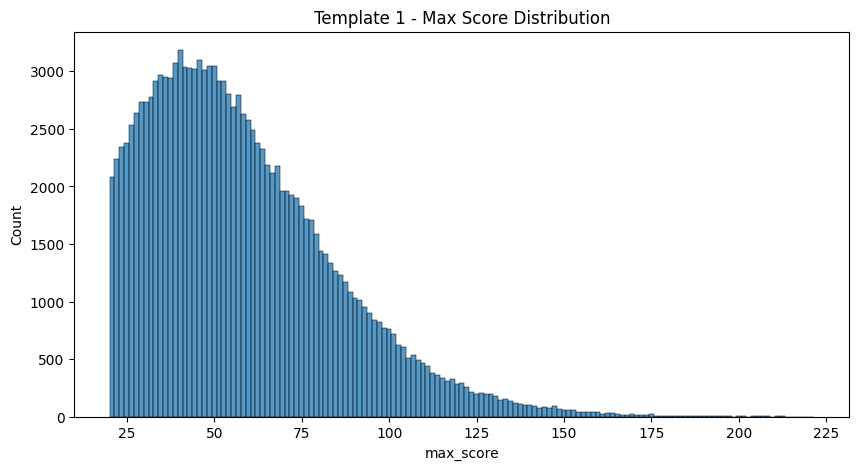

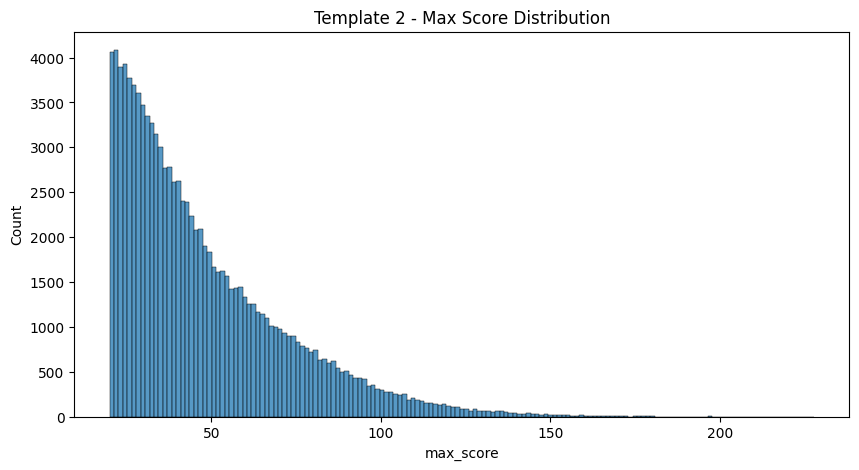

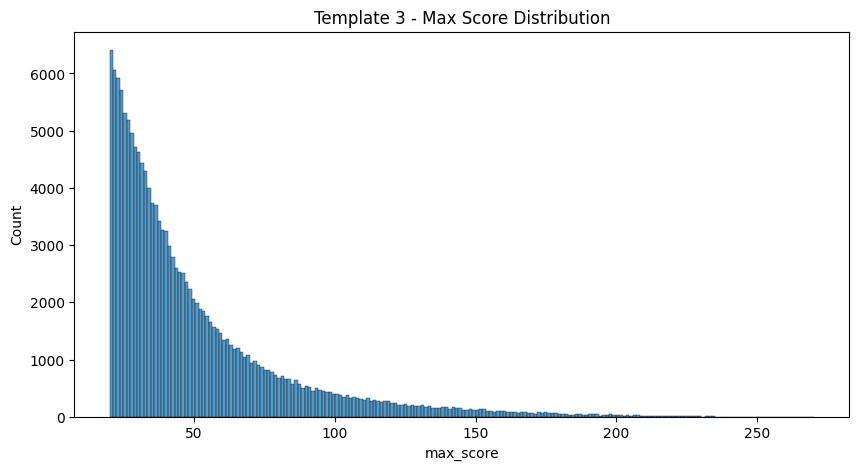

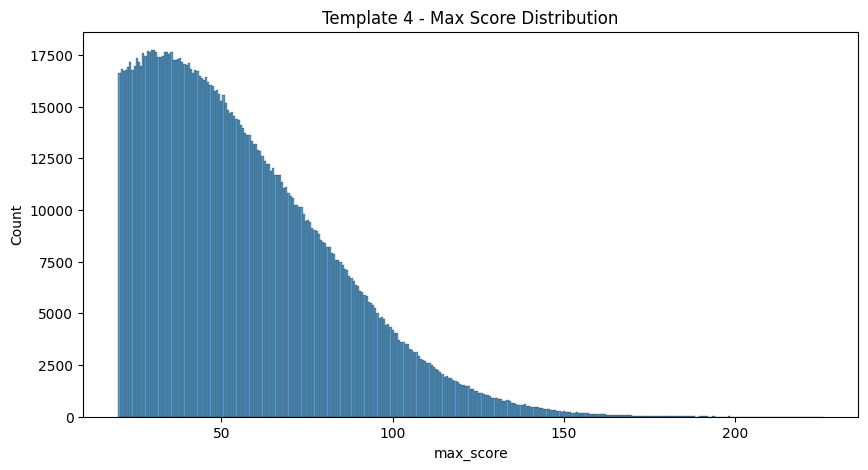

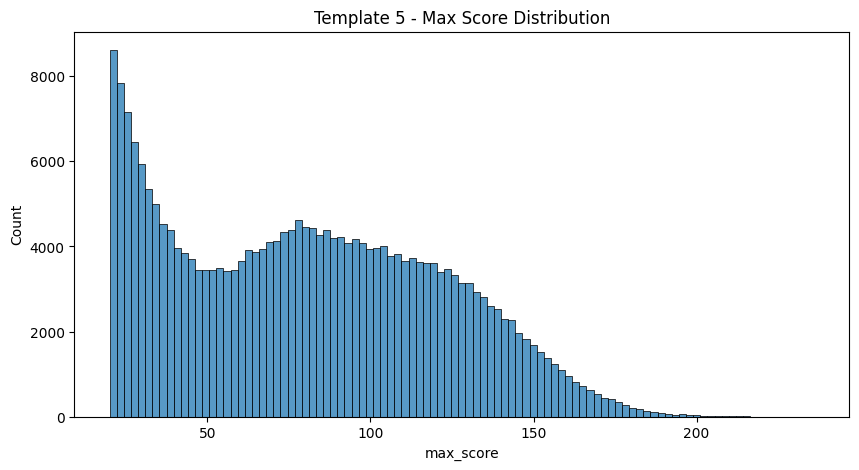

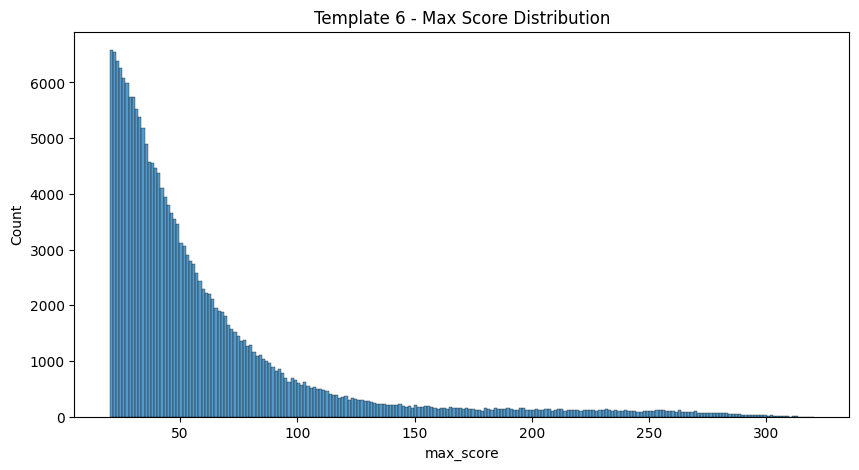

In [204]:
for i in [0, 1, 2, 3, 4, 5, 6]:
    st_temp = st[st['template_id'] == i]
    plt.figure(figsize=(10, 5))
    sns.histplot(st_temp['max_score'])
    plt.title(f"Template {i} - Max Score Distribution")
    plt.show()

In [209]:
st['template_id'].value_counts()

template_id
4.0    1150051
5.0     193349
6.0     112859
1.0      97071
3.0      73707
0.0      67753
2.0      55814
Name: count, dtype: int64